<a href="https://colab.research.google.com/github/ricardoV94/ThinkBayesPymc3/blob/master/ThinkBayes_Chapter_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
pip install arviz

In [0]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [0]:
def get_price_data():
    # Load first dataset
    df1 = pd.read_csv('http://thinkbayes.com/showcases.2011.csv', index_col=0, header=None).T
    df1 = df1.iloc[:, [0,1,3,4,6,7,9,10]]
    df1.columns = ['Date', 'Episode','Show1', 'Show2', 'Bid1', 'Bid2', 'Dif1', 'Dif2']

    # Load second dataset
    df2 = pd.read_csv('http://thinkbayes.com/showcases.2012.csv', index_col=0, header=None).T
    df2 = df2.iloc[:, [0,1,2,3,5,6,8,9]]
    df2.columns = ['Date', 'Episode','Show1', 'Show2', 'Bid1', 'Bid2', 'Dif1', 'Dif2']

    # Merge datasets and fix data type
    df = pd.concat((df1, df2))
    df = df.apply(pd.to_numeric, errors='ignore')
    return df

In [4]:
df = get_price_data()
df.head()

,Date,Episode,Show1,Show2,Bid1,Bid2,Dif1,Dif2
1,Sep. 19,5631K,50969,45429,42000,34000,8969,11429
2,Sep. 20,5632K,21901,34061,14000,59900,7901,-25839
3,Sep. 21,5633K,32815,53186,32000,45000,815,8186
4,Sep. 22,5634K,44432,31428,27000,38000,17432,-6572
5,Sep. 23,5635K,24273,22320,18750,23000,5523,-680


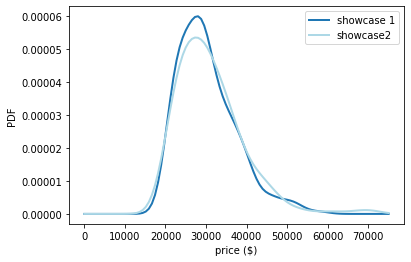

In [5]:
y1 = st.gaussian_kde(df['Show1'])
y2 = st.gaussian_kde(df['Show2'])
x = np.linspace(0, 75_000, 100)
plt.plot(x, y1(x), label='showcase 1', lw=2)
plt.plot(x, y2(x), label='showcase2', color='lightblue', lw=2)
plt.ylabel('PDF')
plt.xlabel('price ($)')
plt.legend();

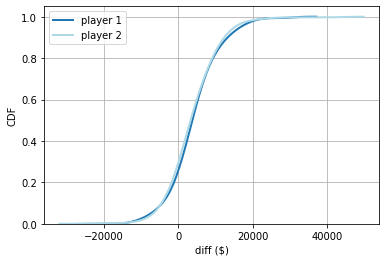

In [6]:
sns.kdeplot(df['Dif1'], cumulative=True, linewidth=2, label='player 1')
sns.kdeplot(df['Dif2'], cumulative=True, color='lightblue', linewidth=2, label='player 2')
plt.grid()
plt.ylabel('CDF')
plt.xlabel('diff ($)');

In [0]:
def estimate_pdf(param, samples, _min=None, _max=None):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin

    x = np.linspace(smin, smax, 100)
    y = st.gaussian_kde(samples)(x)

    # Extend beyond samples range
    if _min is None:
        _min = smin - 3 * width
    if _max is None:
        _max = smax + 3 * width
    x = np.concatenate([[_min], x, [_max]])
    y = np.concatenate([[0], y, [0]])
    
    return pm.Interpolated(param, x, y)#, testval=np.mean(samples))

In [0]:
def run_model_6(prices, differences, observed=None, samples=3000):
    with pm.Model() as m:
        true_price = estimate_pdf('true_price', prices, 10_000, 75_000)
        guess = pm.Normal('guess', mu=true_price, sigma=np.std(differences), observed=observed)
        
        trace_m = pm.sample(samples, progressbar=False)
    return trace_m

In [9]:
prior_traces = []
posterior_traces = []

prior_traces.append(run_model_6(df['Show1'], df['Dif1']))
prior_traces.append(run_model_6(df['Show2'], df['Dif2']))

posterior_traces.append(run_model_6(df['Show1'], df['Dif1'], observed=20_000))
posterior_traces.append(run_model_6(df['Show2'], df['Dif2'], observed=40_000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [guess, true_price]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [guess, true_price]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [true_price]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [true_price]


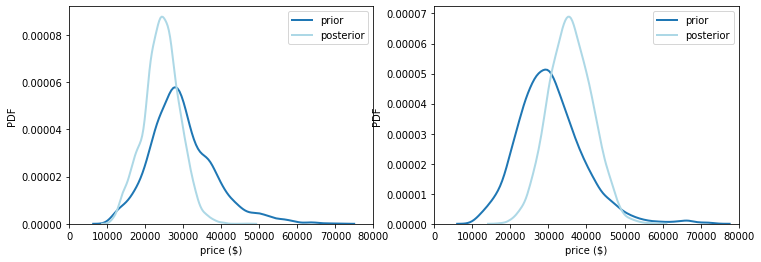

In [10]:
_, ax = plt.subplots(1, 2, figsize=(12,4))
for i, axi in enumerate(ax.ravel()):
    sns.distplot(prior_traces[i]['true_price'], hist=False, label='prior', kde_kws={'linewidth': 2}, ax=axi)
    sns.distplot(posterior_traces[i]['true_price'], hist=False, label='posterior', color='lightblue', kde_kws={'linewidth':2}, ax=axi)
    axi.set_xlim([0, 80_000])
    axi.set_ylabel('PDF')
    axi.set_xlabel('price ($)');

In [11]:
print(f"1: Prior mean = {np.mean(prior_traces[0]['true_price']):.0f} -> Posterior mean = {np.mean(posterior_traces[0]['true_price']):.0f}")
print(f"2: Prior mean = {np.mean(prior_traces[1]['true_price']):.0f} -> Posterior mean = {np.mean(posterior_traces[1]['true_price']):.0f}")

1: Prior mean = 29686 -> Posterior mean = 24296
2: Prior mean = 30605 -> Posterior mean = 35798


## 6.8 Optimal bidding

In [0]:
# Calculate expected gains
def expected_gains(player_trace, opponent_error):

    x_range = np.linspace(0, 75_000, 101)

    posterior_price_pdf = st.gaussian_kde(player_trace['true_price'])
    posterior_price_pmf = posterior_price_pdf(x_range)
    posterior_price_pmf /= np.sum(posterior_price_pmf)

    prob_opponent_overbid = np.mean(opponent_error < 0)

    # Compute expected gains for each possible bid
    gains = []
    for bid in x_range:

        # For each possible bid integrate over possible real prices
        bid_gain = 0
        for price, prob in zip(x_range, posterior_price_pmf):

            # Gains are only possible if bid was below or equal to price
            if bid > price:
                gain = 0

            else:                        
                diff = price - bid

                prob_win = (
                    prob_opponent_overbid +            # Probability that opponent will overbid
                    np.mean(opponent_error > diff)     # Probability that opponent will underbid by a larger margin        
                )

                if diff <= 250:
                    gain = price*prob_win*2 # approximation (can also use posterior of opponent true_price)
                else:
                    gain = price*prob_win

            bid_gain += prob * gain
        gains.append(bid_gain)

    return x_range, gains

In [0]:
x_range, gains_p1 = expected_gains(posterior_traces[0], df['Dif2'])
x_range, gains_p2 = expected_gains(posterior_traces[1], df['Dif1'])

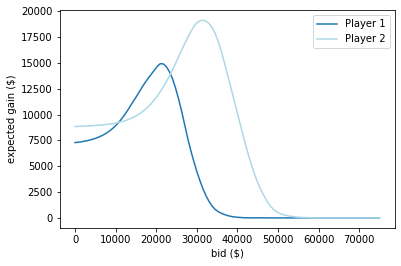

In [14]:
plt.plot(x_range, gains_p1, label='Player 1')
plt.plot(x_range, gains_p2, label='Player 2', color='lightblue')

plt.ylabel('expected gain ($)')
plt.xlabel('bid ($)')
plt.legend();

In [15]:
gain, bid = max(zip(gains_p1, x_range))
print(f'Optimal bid P1: {bid:.0f} -> expected gain: {gain:.0f}$')
gain, bid = max(zip(gains_p2, x_range))
print(f'Optimal bid P2: {bid:.0f} -> expected gain: {gain:.0f}$')

Optimal bid P1: 21000 -> expected gain: 14916$
Optimal bid P2: 31500 -> expected gain: 19118$
